<a href="https://colab.research.google.com/github/sergiomora03/AdvancedTopicsAnalytics/blob/main/exercises/P1-MovieGenrePrediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Movie Genre Classification

Classify a movie genre based on its plot.

<img src="https://raw.githubusercontent.com/sergiomora03/AdvancedTopicsAnalytics/main/notebooks/img/moviegenre.png"
     style="float: left; margin-right: 10px;" />



### Data

Input:
- movie plot

Output:
Probability of the movie belong to each genre


### Evaluation

- 30% Report with all the details of the solution, the analysis and the conclusions. The report cannot exceed 10 pages, must be send in PDF format and must be self-contained.
- 30% Code with the data processing and models developed that support the reported results.
- 30% Presentation of no more than 15 minutes with the main results of the project.
- 10% Model performance achieved. Metric: "AUC".

• The project must be carried out in groups of 4 people.
• Use clear and rigorous procedures.
• The delivery of the project is on September 8th, 2023, 11:59 pm, through email.
• No projects will be received after the delivery time or by any other means than the one established.




### Acknowledgements

We thank Professor Fabio Gonzalez, Ph.D. and his student John Arevalo for providing this dataset.

See https://arxiv.org/abs/1702.01992

## Sample Submission

In [ ]:
import pandas as pd
import os
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.multiclass import OneVsOneClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import r2_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, KFold
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string
import gensim
from gensim.models import Word2Vec
from tensorflow.keras.layers import Embedding, GRU, Dense
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
dataTraining = pd.read_csv('https://github.com/sergiomora03/AdvancedTopicsAnalytics/raw/main/datasets/dataTraining.zip', encoding='UTF-8', index_col=0)
dataTesting = pd.read_csv('https://github.com/sergiomora03/AdvancedTopicsAnalytics/raw/main/datasets/dataTesting.zip', encoding='UTF-8', index_col=0)

In [ ]:
dataTraining.shape

In [ ]:
dataTraining.head()

,year,title,plot,genres,rating
3107,2003,Most,most is the story of a single father who takes...,"['Short', 'Drama']",8.0
900,2008,How to Be a Serial Killer,a serial killer decides to teach the secrets o...,"['Comedy', 'Crime', 'Horror']",5.6
6724,1941,A Woman's Face,"in sweden , a female blackmailer with a disfi...","['Drama', 'Film-Noir', 'Thriller']",7.2
4704,1954,Executive Suite,"in a friday afternoon in new york , the presi...",['Drama'],7.4
2582,1990,Narrow Margin,"in los angeles , the editor of a publishing h...","['Action', 'Crime', 'Thriller']",6.6


In [ ]:
dataTesting.head()

,year,title,plot
1,1999,Message in a Bottle,"who meets by fate , shall be sealed by fate ...."
4,1978,Midnight Express,"the true story of billy hayes , an american c..."
5,1996,Primal Fear,martin vail left the chicago da ' s office to ...
6,1950,Crisis,husband and wife americans dr . eugene and mr...
7,1959,The Tingler,the coroner and scientist dr . warren chapin ...


### Create count vectorizer


In [ ]:
#thing to note here is that we are only using the words in the plot field to build up the vocabulary
vect = CountVectorizer(max_features=1000)
X_dtm = vect.fit_transform(dataTraining['plot'])
X_dtm.shape

(7895, 1000)

In [ ]:
X_dtm

<7895x1000 sparse matrix of type '<class 'numpy.int64'>'
	with 398173 stored elements in Compressed Sparse Row format>

In [ ]:
X_dtm[0]

<1x1000 sparse matrix of type '<class 'numpy.int64'>'
	with 83 stored elements in Compressed Sparse Row format>

In [ ]:
print(list(vect.vocabulary_.keys())[:50])

['most', 'is', 'the', 'story', 'of', 'single', 'father', 'who', 'takes', 'his', 'year', 'old', 'son', 'to', 'work', 'with', 'him', 'at', 'where', 'he', 'day', 'before', 'boy', 'meets', 'woman', 'train', 'drug', 'goes', 'into', 'room', 'and', 'tells', 'stay', 'ship', 'comes', 'though', 'it', 'arrive', 'an', 'later', 'happens', 'sees', 'this', 'tries', 'not', 'able', 'see', 'just', 'as', 'falls']


### Create y

In [ ]:
dataTraining['genres'] = dataTraining['genres'].map(lambda x: eval(x))

le = MultiLabelBinarizer()
y_genres = le.fit_transform(dataTraining['genres'])

In [ ]:
y_genres

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 1, 0, 0],
       ...,
       [0, 1, 0, ..., 0, 0, 0],
       [0, 1, 1, ..., 0, 0, 0],
       [0, 1, 1, ..., 0, 0, 0]])

In [ ]:
le.classes_

array(['Action', 'Adventure', 'Animation', 'Biography', 'Comedy', 'Crime',
       'Documentary', 'Drama', 'Family', 'Fantasy', 'Film-Noir',
       'History', 'Horror', 'Music', 'Musical', 'Mystery', 'News',
       'Romance', 'Sci-Fi', 'Short', 'Sport', 'Thriller', 'War',
       'Western'], dtype=object)

In [ ]:
len(le.classes_)

24

In [ ]:
y_genres[3107] # shit the problem is also here too wtf

array([1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1,
       0, 0])

In [ ]:
X_train, X_test, y_train_genres, y_test_genres = train_test_split(X_dtm, y_genres, test_size=0.33, random_state=42)

### Train multi-class multi-label model

In [ ]:
clf = OneVsRestClassifier(RandomForestClassifier(n_jobs=-1, n_estimators=100, max_depth=10, random_state=42))

In [ ]:
clf.fit(X_train, y_train_genres)

OneVsRestClassifier(estimator=RandomForestClassifier(max_depth=10, n_jobs=-1,
                                                     random_state=42))

In [ ]:
y_pred_genres = clf.predict_proba(X_test)

In [ ]:
roc_auc_score(y_test_genres, y_pred_genres, average='macro')

0.7812262183677007

# Random Forest with TD-IDF

Let's switch out the vectorizer first since the RF Classifier isn't doing too bad

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

vect = TfidfVectorizer(stop_words='english')
X_dtm = vect.fit_transform(dataTraining['plot'])
features = vect.vocabulary_.keys()
X_dtm.shape

(7895, 38370)

In [ ]:
X_train, X_test, y_train_genres, y_test_genres = train_test_split(X_dtm, y_genres, test_size=0.33, random_state=42)

In [ ]:
clf = OneVsRestClassifier(RandomForestClassifier(n_jobs=-1, n_estimators=100, max_depth=10, random_state=42))

In [ ]:
clf.fit(X_train, y_train_genres)

OneVsRestClassifier(estimator=RandomForestClassifier(max_depth=10, n_jobs=-1,
                                                     random_state=42))

In [ ]:
y_pred_genres = clf.predict_proba(X_test)

In [ ]:
roc_auc_score(y_test_genres, y_pred_genres, average='macro')

0.7939687899847

A little better but, maybe increase the n-gram size , further increasing the dictionary.

In [ ]:
vect = TfidfVectorizer(stop_words='english',ngram_range=(1, 2), min_df=2, max_df=0.95)
X_dtm = vect.fit_transform(dataTraining['plot'])
features = vect.vocabulary_.keys()
X_dtm.shape

(7895, 51746)

In [ ]:
X_train, X_test, y_train_genres, y_test_genres = train_test_split(X_dtm, y_genres, test_size=0.33, random_state=42)

In [ ]:
clf = OneVsRestClassifier(RandomForestClassifier(n_jobs=-1, n_estimators=100, max_depth=25, random_state=42))

In [ ]:
clf.fit(X_train, y_train_genres)

OneVsRestClassifier(estimator=RandomForestClassifier(max_depth=25, n_jobs=-1,
                                                     random_state=42))

In [ ]:
y_pred_genres = clf.predict_proba(X_test)

In [ ]:
roc_auc_score(y_test_genres, y_pred_genres, average='macro')

0.8107723036823163

This results in adding ngrams and depth seem to make a little better score. continue increasing to get to at least 85? max_df lower, min_df increase, max_depth increase

n_grams = (1,4) , min_df = 4 , max_df = 0.8 , max_depth = 15 resulted in 81% \
n_grams = (1,4) , min_df = 5 , max_df = 0.7 , max_depth = 20 resulted in 80% \
n_grams = (1,4) , min_df = 2 , max_df = 0.6 , max_depth = 20 resulted in 81% \
n_grams = (1,6) , min_df = 3 , max_df = 0.6 , max_depth = 25 resulted in 81% \
n_grams = (1,2) , min_df = 2 , max_df = 0.9 , max_depth = 25 resulted in 81% \
n_grams = (2,2) , min_df = 2 , max_df = 0.95 , max_depth = 25 resulted in 67% \
n_grams = (1,2) , min_df = 2 , max_df = 0.95 , max_depth = 25 resulted in 81% \

# One vs Rest Logistic Regression with TD-IDF

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
vect = TfidfVectorizer(stop_words='english',ngram_range=(1, 2), min_df=2, max_df=0.95)
X_dtm = vect.fit_transform(dataTraining['plot'])
features = vect.vocabulary_.keys()
X_dtm.shape

(7895, 51746)

In [ ]:
X_train, X_test, y_train_genres, y_test_genres = train_test_split(X_dtm, y_genres, test_size=0.33, random_state=42)

In [ ]:
clf = OneVsRestClassifier(LogisticRegression())

In [ ]:
clf.fit(X_train, y_train_genres)

OneVsRestClassifier(estimator=LogisticRegression())

In [ ]:
y_pred_genres = clf.predict_proba(X_test)

In [ ]:
roc_auc_score(y_test_genres, y_pred_genres, average='macro')

0.875801684876896

Logistic Regression generated a model with 87% accuracy! Changing the parameters with the Tf-idf vectorizer isn't making it much better \

Let's add k-fold cross validation to make sure we are consistent with 87%

Do a grid parameter search here to optimize it

In [14]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
import numpy as np

X_train, X_test, y_train_genres, y_test_genres = train_test_split(dataTraining['plot'], y_genres, test_size=0.33, random_state=42)

# Define the pipeline
pipeline = Pipeline([
    ('vect', TfidfVectorizer(stop_words='english')),
    ('clf', OneVsRestClassifier(LogisticRegression()))
])

# Define the parameter grid
parameters = {
    'vect__ngram_range': [(1, 1), (1, 2), (1, 3), (1, 4)],
    'vect__max_features': (None, 5000, 10000, 50000),
    'vect__norm': ['l1', 'l2'],
    'vect__min_df': [1, 2, 3],
    'vect__max_df': [0.9, 0.95, 1.0],
    #'clf__estimator__C': np.logspace(-2, 2, 5),
    'clf__estimator__C': [0.1, 1.0, 10.0],
    'clf__estimator__penalty': ['l1', 'l2']
}

# Perform grid search
grid_search = GridSearchCV(pipeline, parameters, cv=5, n_jobs=-1, verbose=1, scoring='roc_auc')
grid_search.fit(X_train, y_train_genres)

# Best parameters
print("Best parameters found:")
print(grid_search.best_params_)

# Best ROC AUC score
print("Best ROC AUC score found:", grid_search.best_score_)

# Predict on the test set with the best model
y_pred_genres = grid_search.predict_proba(X_test)
roc_auc = roc_auc_score(y_test_genres, y_pred_genres, average='macro')
print("ROC AUC on test set:", roc_auc)


Fitting 5 folds for each of 1728 candidates, totalling 8640 fits


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


KeyboardInterrupt: 

#Fitted  Parameters for Logistic Regression using TF-IDF

In [22]:
vect = TfidfVectorizer(stop_words='english',ngram_range=(1, 1), min_df=1, max_df=0.9, max_features=None)
X_dtm = vect.fit_transform(dataTraining['plot'])
features = vect.vocabulary_.keys()
X_dtm.shape

(7895, 38370)

In [23]:
X_train, X_test, y_train_genres, y_test_genres = train_test_split(X_dtm, y_genres, test_size=0.33, random_state=42)

In [28]:
penalty = 'l2'  # or 'l1'
C_value = 0.1  # Adjust C value as needed

# Instantiate Logistic Regression with desired penalty and C value
log_reg = LogisticRegression(penalty=penalty, C=C_value)


In [29]:
clf = OneVsRestClassifier(log_reg)

In [30]:
clf.fit(X_train, y_train_genres)

OneVsRestClassifier(estimator=LogisticRegression(C=0.1))

In [31]:
y_pred_genres = clf.predict_proba(X_test)

In [32]:
roc_auc_score(y_test_genres, y_pred_genres, average='macro')

0.8721695633695384

# Kfold Cross validation

In [ ]:
from sklearn.model_selection import KFold, cross_val_score

In [ ]:
# Set up the cross-validation
cv = KFold(n_splits=10, random_state=1, shuffle=True)

# Get the predicted probabilities for each fold
y_pred_proba = cross_val_predict(clf, X, y, cv=cv, method="predict_proba")

# Calculate the ROC AUC score for each fold and then average them
roc_auc_scores = [roc_auc_score(y, y_pred_proba[:, i]) for i in range(y_pred_proba.shape[1])]
average_roc_auc_score = np.mean(roc_auc_scores)

# Report performance
print('Average ROC AUC Score: %.3f' % average_roc_auc_score)

#One vs Rest Logistic Regression with Count Vectorizer

In [ ]:
vect = CountVectorizer(max_features=1000)
X_dtm = vect.fit_transform(dataTraining['plot'])
X_dtm.shape

(7895, 1000)

In [ ]:
X_train, X_test, y_train_genres, y_test_genres = train_test_split(X_dtm, y_genres, test_size=0.33, random_state=42)

In [ ]:
clf = OneVsRestClassifier(LogisticRegression())

In [ ]:
clf.fit(X_train, y_train_genres)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

OneVsRestClassifier(estimator=LogisticRegression())

In [ ]:
y_pred_genres = clf.predict_proba(X_test)

In [ ]:
roc_auc_score(y_test_genres, y_pred_genres, average='macro')

0.794274780270904

CountVectorizer did not behave as well -> 79%

#One Vs Rest Logistic Regression with Glove embeddings

In [ ]:
!pip install zeugma

  Preparing metadata (setup.py) ... done
  Created wheel for zeugma: filename=zeugma-0.49-py3-none-any.whl size=8790 sha256=9e3bebd5261f402f13c7475ff6fa924543be469a2f1fb8f78b5933313f9e7d94
  Stored in directory: /root/.cache/pip/wheels/33/55/16/3d9155ec34c3a4b3c5488ea8905fd994a6cafd68b8e3e26489
Successfully built zeugma


In [ ]:
from zeugma.embeddings import EmbeddingTransformer

In [ ]:
#setup glove embeddings
glove_model = EmbeddingTransformer('glove')

[==================================================] 100.0% 104.8/104.8MB downloaded


In [ ]:
# Example function to aggregate document embeddings (e.g., averaging)
def aggregate_embeddings(doc_words, embeddings_model):
    doc_embeddings = embeddings_model.transform([' '.join(doc_words)])[0]
    # Calculate the mean embedding
    return np.mean(doc_embeddings, axis=0)

# Example document embeddings
doc_embeddings = [aggregate_embeddings(doc.split(), glove_model) for doc in dataTraining['plot']]


In [ ]:
X_train, X_test, y_train_genres, y_test_genres = train_test_split(np.vstack(doc_embeddings), y_genres, test_size=0.33, random_state=42)

In [ ]:
clf = OneVsRestClassifier(LogisticRegression())

In [ ]:
clf.fit(X_train, y_train_genres)

OneVsRestClassifier(estimator=LogisticRegression())

In [ ]:
y_pred_genres = clf.predict_proba(X_test)

In [ ]:
roc_auc_score(y_test_genres, y_pred_genres, average='macro')

0.5600930513905559

ROC Score of 0.5600930513905559 , don't think this one is going to work better than TF-IDF

# One Vs Rest SVM with TD-IDF

In [ ]:
vect = TfidfVectorizer(stop_words='english',ngram_range=(1, 2), min_df=2, max_df=0.95)
X_dtm = vect.fit_transform(dataTraining['plot'])
features = vect.vocabulary_.keys()
X_dtm.shape

(7895, 51746)

In [ ]:
X_train, X_test, y_train_genres, y_test_genres = train_test_split(X_dtm, y_genres, test_size=0.33, random_state=42)

In [ ]:
clf = OneVsRestClassifier(SVC())

In [ ]:
clf.fit(X_train, y_train_genres)

OneVsRestClassifier(estimator=SVC())

In [ ]:
#y_pred_genres = clf.predict_proba(X_test)
y_pred_genres = clf.predict(X_test)

In [ ]:
roc_auc_score(y_test_genres, y_pred_genres, average='macro')

0.5270409587370896

SVM did not work well with the TF-IDF settings that worked well with Logistic Regression -> 52%

#OneVsRest LinearSVM with Count Vectorizer

In [ ]:
vect = CountVectorizer(max_features=1000)
X_dtm = vect.fit_transform(dataTraining['plot'])
X_dtm.shape

In [ ]:
X_train, X_test, y_train_genres, y_test_genres = train_test_split(X_dtm, y_genres, test_size=0.33, random_state=42)

In [ ]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC
svm_model = OneVsRestClassifier(LinearSVC(loss='hinge'))
svm_model.fit(X_train, y_train_genres)

In [ ]:
y_pred_genres = svm_model.predict(X_test)

In [ ]:
roc_auc_score(y_test_genres, y_pred_genres, average='macro')

# Mutlinomial Naive Bayes with TF-IDF

In [ ]:
from sklearn.naive_bayes import MultinomialNB

In [ ]:
vect = TfidfVectorizer(stop_words='english',ngram_range=(1, 2), min_df=2, max_df=0.95)
X_dtm = vect.fit_transform(dataTraining['plot'])
features = vect.vocabulary_.keys()
X_dtm.shape

(7895, 51746)

In [ ]:
X_train, X_test, y_train_genres, y_test_genres = train_test_split(X_dtm, y_genres, test_size=0.33, random_state=42)

In [ ]:
clf = OneVsRestClassifier(MultinomialNB())

In [ ]:
clf.fit(X_train, y_train_genres)

OneVsRestClassifier(estimator=MultinomialNB())

In [ ]:
y_pred_genres = clf.predict(X_test)

In [ ]:
roc_auc_score(y_test_genres, y_pred_genres, average='macro')

0.5088960524353358

Naive Bayes doesn't work too well -> 50%

#XGBoost with TF-IDF

In [ ]:
import xgboost as xgb

In [ ]:
vect = TfidfVectorizer(stop_words='english',ngram_range=(1, 2), min_df=2, max_df=0.95)
X_dtm = vect.fit_transform(dataTraining['plot'])
features = vect.vocabulary_.keys()
X_dtm.shape

(7895, 51746)

In [ ]:
X_train, X_test, y_train_genres, y_test_genres = train_test_split(X_dtm, y_genres, test_size=0.33, random_state=42)

In [ ]:
clf = OneVsRestClassifier(xgb.XGBClassifier(objective='multi:softmax', num_class=len(le.classes_)))

In [ ]:
clf.fit(X_train, y_train_genres)

OneVsRestClassifier(estimator=XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=None, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=None,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=None, n_jobs=None,
                                            num_class=24,
                                            num_parallel_tree=None, ...))

In [ ]:
y_pred_genres = clf.predict(X_test)

In [ ]:
roc_auc_score(y_test_genres, y_pred_genres, average='macro')

0.6104668443423281

Results in a ROC score of 61%

## Try a Grid Search of the kernels

In [ ]:
class_counts = dataTraining['genres'].value_counts()

In [ ]:
class_counts

Due to fitting of the SVM , seems like we need to remove all those that have only 1 instance to not get soo many metric errors during fitting

In [ ]:
# Define a threshold for the minimum number of instances per class
min_instances = 3

# Identify classes with less than `min_instances` instances
underrepresented_classes = class_counts[class_counts < min_instances].index

# Option 1: Remove underrepresented classes
dataTraining2 = dataTraining[~dataTraining['genres'].isin(underrepresented_classes)]

In [ ]:
class_counts = dataTraining2['genres'].value_counts()

In [ ]:
class_counts

In [ ]:
vect = TfidfVectorizer(stop_words='english',ngram_range=(1, 2), min_df=2, max_df=0.95)
X_dtm = vect.fit_transform(dataTraining2['plot'])
features = vect.vocabulary_.keys()
X_dtm.shape

In [ ]:
dataTraining2['genres'] = dataTraining2['genres'].map(lambda x: eval(x))

le = MultiLabelBinarizer()
y_genres = le.fit_transform(dataTraining2['genres'])

In [ ]:
#sub sample because this takes too long
X_sample, _, y_sample, _ = train_test_split(X_dtm, y_genres, test_size=0.5, random_state=42, stratify=y_genres)
X_train, X_test, y_train_genres, y_test_genres = train_test_split(X_sample, y_sample, test_size=0.33, random_state=42, stratify=y_sample)

In [ ]:
X_train.shape

In [ ]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score
from sklearn.metrics import make_scorer, precision_score, recall_score, fbeta_score

# Define the OneVsRestClassifier with SVC as the estimator
model_to_set = OneVsRestClassifier(SVC())

# Define the parameter grid for grid search
parameters = {
    #"estimator__C": [1, 2, 4, 8],
    #"estimator__kernel": ["poly", "rbf", "linear"],
    #"estimator__degree": [1, 2, 3, 4],
    "estimator__C": [1,10],
    "estimator__kernel": ["poly", "rbf", "linear"],
}

precision_scorer = make_scorer(precision_score, average='weighted')

# Create the GridSearchCV object
model_tuning = GridSearchCV(model_to_set, param_grid=parameters, scoring=precision_scorer , cv = 5)

# Fit the model
model_tuning.fit(X_train, y_train_genres)

# Print the best score and parameters
print(model_tuning.best_score_)
print(model_tuning.best_params_)

apparently using OneVsRest when the base model is SVC doesn't make a whole lot of sense

# Using Word2Vec as the embedding model

In [ ]:
dataTraining = pd.read_csv('https://github.com/sergiomora03/AdvancedTopicsAnalytics/raw/main/datasets/dataTraining.zip', encoding='UTF-8', index_col=0)
dataTesting = pd.read_csv('https://github.com/sergiomora03/AdvancedTopicsAnalytics/raw/main/datasets/dataTesting.zip', encoding='UTF-8', index_col=0)

In [ ]:
dataTraining.isna().any()

In [ ]:
dataTraining.shape

In [ ]:
dataTesting.isna().any()

In [ ]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string

In [ ]:
nltk.download('punkt')
nltk.download('stopwords')

In [ ]:
# Remove punctuation and convert to lowercase
dataTraining['plot'] = dataTraining['plot'].apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)).lower())

In [ ]:
stop_words = set(stopwords.words('english'))

In [ ]:
dataTraining['plot'] = dataTraining['plot'].apply(lambda x: [word for word in word_tokenize(x) if word.isalnum() and word not in stop_words])

In [ ]:
import gensim
from gensim.models import Word2Vec

In [ ]:
word2vec_model = Word2Vec(sentences=dataTraining['plot'], vector_size=100, window=5, min_count=1, workers=4)

In [ ]:
def get_doc_vector(tokens, model):
    vector = [model.wv[word] for word in tokens if word in model.wv.index_to_key]
    if not vector:
        return None
    return sum(vector) / len(vector) if vector else None

In [ ]:
dataTraining['plot'] = dataTraining['plot'].apply(lambda x: get_doc_vector(x, word2vec_model))

In [ ]:
dataTraining.isna().any()

In [ ]:
dataTraining = dataTraining.dropna()

In [ ]:
dataTraining.isna().any()

In [ ]:
dataTraining.shape

In [ ]:
dataTraining['genres'] = dataTraining['genres'].map(lambda x: eval(x))

multilabel_binarizer = MultiLabelBinarizer()
#dataTraining['encoded_genres'] = multilabel_binarizer.fit_transform(dataTraining['genres']).tolist()
y_genres =  multilabel_binarizer.fit_transform(dataTraining['genres'])

In [ ]:
X_dtm = dataTraining['plot']

In [ ]:
X_train, X_test, y_train_genres, y_test_genres = train_test_split(X_dtm, y_genres, test_size=0.2, random_state=42)

In [ ]:
X_train[0].shape

In [ ]:
y_train_genres[0]

In [ ]:
clf = OneVsRestClassifier(RandomForestClassifier(n_jobs=-1, n_estimators=100, max_depth=10, random_state=42))
clf.fit(X_train.tolist(), y_train_genres)

In [ ]:
#clf = OneVsRestClassifier(LogisticRegression())
#clf.fit(np.array(X_train).tolist(), y_train_genres)
#clf.fit(X_train.tolist(), y_train.tolist())
#clf.fit(np.array(X_train).tolist(), np.array(y_train).tolist())

In [ ]:
y_pred_genres = clf.predict(X_test.tolist())

In [ ]:
roc_auc_score(y_test_genres, y_pred_genres, average='macro')

Using word2vec results in a worse prediction. Thing to note, the fitting heavily realied on the tolist() function invoked on the X_dtm dataset , so it's very possible the Final Vector Feature for the Classifier is causing some problems

# GRU with keras Tokenizer

In [ ]:
dataTraining = pd.read_csv('https://github.com/sergiomora03/AdvancedTopicsAnalytics/raw/main/datasets/dataTraining.zip', encoding='UTF-8', index_col=0)
dataTesting = pd.read_csv('https://github.com/sergiomora03/AdvancedTopicsAnalytics/raw/main/datasets/dataTesting.zip', encoding='UTF-8', index_col=0)

In [ ]:
dataTraining['genres'] = dataTraining['genres'].map(lambda x: eval(x))

multilabel_binarizer = MultiLabelBinarizer()
y_genres =  multilabel_binarizer.fit_transform(dataTraining['genres'])

In [ ]:
import numpy as np
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, GRU, Dense


def preprocess(data):
   # Your text cleaning function here
   stop_words = set(stopwords.words('english'))
   data.translate(str.maketrans('', '', string.punctuation)).lower()
   [word for word in word_tokenize(data) if word.isalnum() and word not in stop_words]
   return data

X = dataTraining['plot'].apply(preprocess).values
num_words = 5000
maxlen = 100

X_train, X_test, y_train, y_test = train_test_split(X, y_genres, test_size=0.2, random_state=42)

tokenizer = Tokenizer(num_words=num_words, split=' ', oov_token="UNKNOWN_TOKEN")
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_train = pad_sequences(X_train, maxlen=maxlen, value=0)
X_test = tokenizer.texts_to_sequences(X_test)
X_test = pad_sequences(X_test, maxlen=maxlen, value=0)

model = keras.Sequential()
model.add(keras.layers.Embedding(num_words, 64, input_length=maxlen))
model.add(keras.layers.GRU(256))
model.add(keras.layers.Dense(len(multilabel_binarizer.classes_), activation="sigmoid"))

#optimizer = keras.optimizers.Adam(learning_rate=0.01)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test,y_test))

print("Training accuracy:", history.history['accuracy'][0])
print("Validation accuracy:", history.history['val_accuracy'][0])

Training accuracy: 0.19418051838874817
Validation accuracy: 0.21044303476810455

Ok so now we get to play with RNN architecture



```
model = keras.Sequential()
model.add(keras.layers.Embedding(num_words, 64, input_length=maxlen))
model.add(keras.layers.GRU(64, return_sequences=True))
model.add(keras.layers.Dropout(0.4))
model.add(keras.layers.GRU(64))
model.add(keras.layers.Dense(len(multilabel_binarizer.classes_), activation="sigmoid"))
```





Ok so we are actually getting somewhere with GRU lol , better than a coin flip with 10 epochs with slightly worse training loss... thing is it's taking a while ...

Training accuracy: 0.21516230702400208
Validation accuracy: 0.21044303476810455


```
model = keras.Sequential()
model.add(keras.layers.Embedding(num_words, 64, input_length=maxlen))
model.add(keras.layers.GRU(128))
model.add(keras.layers.Dense(len(multilabel_binarizer.classes_), activation="sigmoid"))
```



Training accuracy: 0.20978467166423798
Validation accuracy: 0.16149461269378662



```
model = keras.Sequential()
model.add(keras.layers.Embedding(num_words, 64, input_length=maxlen))
model.add(keras.layers.GRU(256))
model.add(keras.layers.Dense(len(multilabel_binarizer.classes_), activation="sigmoid"))
```



It's getting worse the bigger the GRU layer...

# GRU with Word2Vec Trained on Plot Summaries

In [ ]:
import tensorflow
import keras

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense
from tensorflow.keras.utils import to_categorical

In [ ]:
dataTraining = pd.read_csv('https://github.com/sergiomora03/AdvancedTopicsAnalytics/raw/main/datasets/dataTraining.zip', encoding='UTF-8', index_col=0)
dataTesting = pd.read_csv('https://github.com/sergiomora03/AdvancedTopicsAnalytics/raw/main/datasets/dataTesting.zip', encoding='UTF-8', index_col=0)

In [ ]:
dataTraining['genres'] = dataTraining['genres'].map(lambda x: eval(x))

multilabel_binarizer = MultiLabelBinarizer()
y_genres =  multilabel_binarizer.fit_transform(dataTraining['genres'])

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, Embedding, GRU, Dense
from sklearn.model_selection import train_test_split
import nltk
nltk.download('punkt')
from gensim import models

# Custom preprocess function (if needed)
def preprocess(data):
   # Your text cleaning function here
   stop_words = set(stopwords.words('english'))
   data.translate(str.maketrans('', '', string.punctuation)).lower()
   [word for word in word_tokenize(data) if word.isalpha() and word not in stop_words]
   return data

# Update these hyperparameters based on requirements
num_words = 5000
embedding_dimension = 128
batch_size = 32
epochs = 10

# Load your dataset
X = dataTraining['plot'].apply(preprocess).values

# Build Word2Vec model
wv_model = models.Word2Vec(min_count=1, vector_size=embedding_dimension, window=5, sg=1, iter=10, workers=-1)
wv_model.build_vocab(X)
wv_model.train(X, total_examples=X.shape[0], epochs=wv_model.iter)


# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(np.array(X), y_genres, test_size=0.2, random_state=42)

model = keras.Sequential()
model.add(keras.layers.Embedding(num_words, 64, input_length=maxlen))
model.add(keras.layers.GRU(256))
model.add(keras.layers.Dense(len(multilabel_binarizer.classes_), activation="sigmoid"))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Training
#history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, class_weight={i: w for i, w in enumerate(class_weights)}, validation_data=(X_test, y_test))
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test))

print("Training accuracy:", history.history['acc'][0])
print("Validation accuracy:", history.history['val_acc'][0])

#GRU using Glove Embeddings

In [ ]:
glove_model = EmbeddingTransformer('glove')

In [ ]:
# Example function to aggregate document embeddings (e.g., averaging)
def aggregate_embeddings(doc_words, embeddings_model):
    doc_embeddings = embeddings_model.transform([' '.join(doc_words)])[0]
    # Calculate the mean embedding
    return np.mean(doc_embeddings, axis=0)

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from tensorflow.keras.layers import Input, Embedding, GRU, Dense
from sklearn.model_selection import train_test_split
import nltk
from gensim import models

# Custom preprocess function (if needed)
def preprocess(data):
   # Your text cleaning function here
   stop_words = set(stopwords.words('english'))
   data.translate(str.maketrans('', '', string.punctuation)).lower()
   [word for word in word_tokenize(data) if word.isalpha() and word not in stop_words]
   return data

X = dataTraining['plot'].apply(preprocess).values

# Tokenize text data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X)
sequences = tokenizer.texts_to_sequences(X)

# Pad sequences
max_sequence_length = 100  # Choose an appropriate sequence length
padded_sequences = pad_sequences(sequences, maxlen=max_sequence_length, truncating='post')  # Truncate longer sequences

# Create embedding matrix
word_index = tokenizer.word_index
num_words = len(word_index) + 1
sample_embedding = glove_model.transform(['sample'])[0]
embedding_dim = len(sample_embedding)
embedding_matrix = np.zeros((num_words, embedding_dim))

for word, i in word_index.items():
    if word in glove_model.model.key_to_index:
        embedding_matrix[i] = glove_model.transform([word])[0]

X_train, X_test, y_train, y_test = train_test_split(np.array(padded_sequences), y_genres, test_size=0.2, random_state=42)


# Define GRU model
model = Sequential()
model.add(Embedding(num_words, embedding_dim, weights=[embedding_matrix], input_length=max_sequence_length, trainable=False))
model.add(GRU(units=32, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(len(le.classes_), activation="sigmoid"))

# Compile model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train model
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/10
198/198 [==============================] - 14s 53ms/step - loss: 0.3716 - accuracy: 0.1678 - val_loss: 0.2986 - val_accuracy: 0.1868
Epoch 2/10
198/198 [==============================] - 10s 51ms/step - loss: 0.2927 - accuracy: 0.2004 - val_loss: 0.2974 - val_accuracy: 0.1868
Epoch 3/10
198/198 [==============================] - 11s 54ms/step - loss: 0.2920 - accuracy: 0.2004 - val_loss: 0.2965 - val_accuracy: 0.1868
Epoch 4/10
198/198 [==============================] - 10s 52ms/step - loss: 0.2912 - accuracy: 0.2006 - val_loss: 0.2952 - val_accuracy: 0.1868
Epoch 5/10
198/198 [==============================] - 12s 58ms/step - loss: 0.2895 - accuracy: 0.2003 - val_loss: 0.2931 - val_accuracy: 0.1868
Epoch 6/10
198/198 [==============================] - 11s 53ms/step - loss: 0.2862 - accuracy: 0.2088 - val_loss: 0.2883 - val_accuracy: 0.2033
Epoch 7/10
198/198 [==============================] - 10s 52ms/step - loss: 0.2803 - accuracy: 0.2278 - val_loss: 0.2806 - val_accuracy:

Puede que este modelo eventualmente llega a punto con alto accuracy porque se nota que aun no hay overfitting.Cambios otras cositas \

198/198 [==============================] - 10s 52ms/step - loss: 0.2668 - accuracy: 0.2638 - val_loss: 0.2679 - val_accuracy: 0.3046



In [ ]:
#create search space code

from keras.callbacks import EarlyStopping
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from tensorflow.keras.layers import Input, Embedding, GRU, Dense
from sklearn.model_selection import train_test_split
import nltk
from gensim import models

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Custom preprocess function (if needed)
def preprocess(data):
   # Your text cleaning function here
   stop_words = set(stopwords.words('english'))
   data.translate(str.maketrans('', '', string.punctuation)).lower()
   [word for word in word_tokenize(data) if word.isalpha() and word not in stop_words]
   return data

X = dataTraining['plot'].apply(preprocess).values

# Tokenize text data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X)
sequences = tokenizer.texts_to_sequences(X)

# Pad sequences
max_sequence_length = 100  # Choose an appropriate sequence length
padded_sequences = pad_sequences(sequences, maxlen=max_sequence_length, truncating='post')  # Truncate longer sequences

# Create embedding matrix
word_index = tokenizer.word_index
num_words = len(word_index) + 1
sample_embedding = glove_model.transform(['sample'])[0] # for finding the dimension of the embedding model we are working with
embedding_dim = len(sample_embedding)
embedding_matrix = np.zeros((num_words, embedding_dim))

for word, i in word_index.items():
    if word in glove_model.model.key_to_index:
        embedding_matrix[i] = glove_model.transform([word])[0]

X_train, X_test, y_train, y_test = train_test_split(np.array(padded_sequences), y_genres, test_size=0.2, random_state=42)


# Define GRU model
model = Sequential()
model.add(Embedding(num_words, embedding_dim, weights=[embedding_matrix], input_length=max_sequence_length, trainable=False))
model.add(GRU(units=32, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(len(le.classes_), activation="sigmoid"))

# Compile model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train model
model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping])


Epoch 1/100
198/198 [==============================] - 13s 55ms/step - loss: 0.3456 - accuracy: 0.1876 - val_loss: 0.2978 - val_accuracy: 0.1868
Epoch 2/100
198/198 [==============================] - 11s 53ms/step - loss: 0.2922 - accuracy: 0.2004 - val_loss: 0.2962 - val_accuracy: 0.1868
Epoch 3/100
198/198 [==============================] - 13s 67ms/step - loss: 0.2905 - accuracy: 0.2004 - val_loss: 0.2942 - val_accuracy: 0.1868
Epoch 4/100
198/198 [==============================] - 11s 55ms/step - loss: 0.2869 - accuracy: 0.2052 - val_loss: 0.2867 - val_accuracy: 0.2381
Epoch 5/100
198/198 [==============================] - 11s 54ms/step - loss: 0.2798 - accuracy: 0.2188 - val_loss: 0.2801 - val_accuracy: 0.1906
Epoch 6/100
198/198 [==============================] - 11s 54ms/step - loss: 0.2756 - accuracy: 0.2250 - val_loss: 0.2761 - val_accuracy: 0.2014
Epoch 7/100
198/198 [==============================] - 11s 55ms/step - loss: 0.2719 - accuracy: 0.2218 - val_loss: 0.2716 - val_ac

By epoch 38 , early stopping called.. \
Epoch 38/100
198/198 [==============================] - 11s 54ms/step - loss: 0.2315 - accuracy: 0.3322 - val_loss: 0.2356 - val_accuracy: 0.3274

In [ ]:
!pip install keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 1.4 MB/s eta 0:00:00


## Keras Tuner for Initial GRU Architecture

In [ ]:
import keras_tuner as kt
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from tensorflow.keras.layers import Input, Embedding, GRU, Dense
from sklearn.model_selection import train_test_split
import nltk
from gensim import models

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Custom preprocess function (if needed)
def preprocess(data):
   # Your text cleaning function here
   stop_words = set(stopwords.words('english'))
   data.translate(str.maketrans('', '', string.punctuation)).lower()
   [word for word in word_tokenize(data) if word.isalpha() and word not in stop_words]
   return data

X = dataTraining['plot'].apply(preprocess).values

# Tokenize text data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X)
sequences = tokenizer.texts_to_sequences(X)

# Pad sequences
max_sequence_length = 100  # Choose an appropriate sequence length
padded_sequences = pad_sequences(sequences, maxlen=max_sequence_length, truncating='post')  # Truncate longer sequences

# Create embedding matrix
word_index = tokenizer.word_index
num_words = len(word_index) + 1
sample_embedding = glove_model.transform(['sample'])[0]
embedding_dim = len(sample_embedding)
embedding_matrix = np.zeros((num_words, embedding_dim))

for word, i in word_index.items():
    if word in glove_model.model.key_to_index:
        embedding_matrix[i] = glove_model.transform([word])[0]

X_train, X_test, y_train, y_test = train_test_split(np.array(padded_sequences), y_genres, test_size=0.2, random_state=42)


# Define a function to create the GRU model
def model_builder(hp):
    model = Sequential()
    model.add(Embedding(num_words, embedding_dim, weights=[embedding_matrix], input_length=max_sequence_length, trainable=False))

    # Define the GRU layer
    hp_units = hp.Int('units', min_value=16, max_value=64, step=16)
    hp_dropout = hp.Choice('dropout', values=[0.0, 0.1, 0.2, 0.3, 0.4])
    hp_recurrent_dropout = hp.Choice('recurrent_dropout', values=[0.0, 0.1, 0.2, 0.3, 0.4])
    model.add(GRU(units=hp_units, dropout=hp_dropout, recurrent_dropout=hp_recurrent_dropout))

    # Output layer
    model.add(Dense(len(le.classes_), activation="sigmoid"))

    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

# Set up the tuner
tuner = kt.Hyperband(
    model_builder,
    objective='val_accuracy',
    max_epochs=100,
    factor=3,
    directory='my_dir',
    project_name='gru_tuning'
)


# Run the tuner
tuner.search(
    X_train,
    y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping],
    verbose=1
)

# Get the best hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

Trial 87 Complete [00h 00m 28s]
val_accuracy: 0.18682710826396942

Best val_accuracy So Far: 0.2653578221797943
Total elapsed time: 00h 41m 16s


In [ ]:
tuner.get_best_hyperparameters(num_trials=1)[0]

In [ ]:
print(best_hps.values)

{'units': 64, 'dropout': 0.4, 'recurrent_dropout': 0.1, 'tuner/epochs': 2, 'tuner/initial_epoch': 0, 'tuner/bracket': 4, 'tuner/round': 0}


Here is what Keras Tuner gave us:

{'units': 64, 'dropout': 0.4, 'recurrent_dropout': 0.1, 'tuner/epochs': 2, 'tuner/initial_epoch': 0, 'tuner/bracket': 4, 'tuner/round': 0}


In [ ]:
# Build the model with the best hyperparameters and train it
model = tuner.hypermodel.build(best_hps)
history = model.fit(
    X_train,
    y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping],
    verbose=1
)


Epoch 1/100
198/198 [==============================] - 16s 69ms/step - loss: 0.3248 - accuracy: 0.2041 - val_loss: 0.2974 - val_accuracy: 0.1868
Epoch 2/100
198/198 [==============================] - 13s 67ms/step - loss: 0.2913 - accuracy: 0.2035 - val_loss: 0.2949 - val_accuracy: 0.1868
Epoch 3/100
198/198 [==============================] - 14s 69ms/step - loss: 0.2873 - accuracy: 0.2076 - val_loss: 0.2886 - val_accuracy: 0.3034
Epoch 4/100
198/198 [==============================] - 13s 67ms/step - loss: 0.2800 - accuracy: 0.2598 - val_loss: 0.2809 - val_accuracy: 0.2153
Epoch 5/100
198/198 [==============================] - 24s 120ms/step - loss: 0.2731 - accuracy: 0.2630 - val_loss: 0.2704 - val_accuracy: 0.2527
Epoch 6/100
198/198 [==============================] - 18s 91ms/step - loss: 0.2664 - accuracy: 0.2714 - val_loss: 0.2648 - val_accuracy: 0.3287
Epoch 7/100
198/198 [==============================] - 14s 70ms/step - loss: 0.2621 - accuracy: 0.2747 - val_loss: 0.2609 - val_a

Re-run the full 100 epochs with a smaller learning rate and updated architecture

In [ ]:
#create search space code

from keras.callbacks import EarlyStopping
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from tensorflow.keras.layers import Input, Embedding, GRU, Dense
from sklearn.model_selection import train_test_split
import nltk
from gensim import models
from keras.optimizers import Adam

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Custom preprocess function (if needed)
def preprocess(data):
   # Your text cleaning function here
   stop_words = set(stopwords.words('english'))
   data.translate(str.maketrans('', '', string.punctuation)).lower()
   [word for word in word_tokenize(data) if word.isalpha() and word not in stop_words]
   return data

X = dataTraining['plot'].apply(preprocess).values

# Tokenize text data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X)
sequences = tokenizer.texts_to_sequences(X)

# Pad sequences
max_sequence_length = 100  # Choose an appropriate sequence length
padded_sequences = pad_sequences(sequences, maxlen=max_sequence_length, truncating='post')  # Truncate longer sequences

# Create embedding matrix
word_index = tokenizer.word_index
num_words = len(word_index) + 1
sample_embedding = glove_model.transform(['sample'])[0] # for finding the dimension of the embedding model we are working with
embedding_dim = len(sample_embedding)
embedding_matrix = np.zeros((num_words, embedding_dim))

for word, i in word_index.items():
    if word in glove_model.model.key_to_index:
        embedding_matrix[i] = glove_model.transform([word])[0]

X_train, X_test, y_train, y_test = train_test_split(np.array(padded_sequences), y_genres, test_size=0.2, random_state=42)



# Define GRU model
model = Sequential()
model.add(Embedding(num_words, embedding_dim, weights=[embedding_matrix], input_length=max_sequence_length, trainable=False))
model.add(GRU(units=64, dropout=0.4, recurrent_dropout=0.1))
model.add(Dense(len(le.classes_), activation="sigmoid"))

adam_optimizer = Adam(lr=0.001) # Set the learning rate to 0.01

# Compile model
model.compile(loss='binary_crossentropy', optimizer=adam_optimizer, metrics=['accuracy'])

# Train model
model.fit(X_train, y_train, epochs=100, batch_size=16, validation_data=(X_test, y_test))


Epoch 1/100
395/395 [==============================] - 26s 62ms/step - loss: 0.3117 - accuracy: 0.1984 - val_loss: 0.2961 - val_accuracy: 0.1906
Epoch 2/100
395/395 [==============================] - 24s 62ms/step - loss: 0.2892 - accuracy: 0.2122 - val_loss: 0.2904 - val_accuracy: 0.1868
Epoch 3/100
395/395 [==============================] - 24s 61ms/step - loss: 0.2800 - accuracy: 0.2407 - val_loss: 0.2780 - val_accuracy: 0.2502
Epoch 4/100
395/395 [==============================] - 25s 62ms/step - loss: 0.2685 - accuracy: 0.2628 - val_loss: 0.2628 - val_accuracy: 0.2932
Epoch 5/100
395/395 [==============================] - 24s 61ms/step - loss: 0.2608 - accuracy: 0.2832 - val_loss: 0.2559 - val_accuracy: 0.2692
Epoch 6/100
395/395 [==============================] - 24s 61ms/step - loss: 0.2564 - accuracy: 0.2954 - val_loss: 0.2528 - val_accuracy: 0.3445
Epoch 7/100
395/395 [==============================] - 24s 62ms/step - loss: 0.2515 - accuracy: 0.3003 - val_loss: 0.2492 - val_ac

In [ ]:
y_pred_genres = model.predict(X_test)

50/50 [==============================] - 2s 20ms/step


In [ ]:
roc_auc_score(y_test, y_pred_genres, average='macro')

0.8461974367709132

Damn , something tells me we can look around to see if an extra layer helps

In [ ]:
#second Keras Tuner for the second layer

import keras_tuner as kt
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from tensorflow.keras.layers import Input, Embedding, GRU, Dense
from sklearn.model_selection import train_test_split
import nltk
from gensim import models

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Custom preprocess function (if needed)
def preprocess(data):
   # Your text cleaning function here
   stop_words = set(stopwords.words('english'))
   data.translate(str.maketrans('', '', string.punctuation)).lower()
   [word for word in word_tokenize(data) if word.isalpha() and word not in stop_words]
   return data

X = dataTraining['plot'].apply(preprocess).values

# Tokenize text data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X)
sequences = tokenizer.texts_to_sequences(X)

# Pad sequences
max_sequence_length = 100  # Choose an appropriate sequence length
padded_sequences = pad_sequences(sequences, maxlen=max_sequence_length, truncating='post')  # Truncate longer sequences

# Create embedding matrix
word_index = tokenizer.word_index
num_words = len(word_index) + 1
sample_embedding = glove_model.transform(['sample'])[0]
embedding_dim = len(sample_embedding)
embedding_matrix = np.zeros((num_words, embedding_dim))

for word, i in word_index.items():
    if word in glove_model.model.key_to_index:
        embedding_matrix[i] = glove_model.transform([word])[0]

X_train, X_test, y_train, y_test = train_test_split(np.array(padded_sequences), y_genres, test_size=0.2, random_state=42)


# Define a function to create the GRU model
def model_builder(hp):
    model = Sequential()
    model.add(Embedding(num_words, embedding_dim, weights=[embedding_matrix], input_length=max_sequence_length, trainable=False))

    hp_units1 = hp.Int('units1', min_value=1, max_value=129, step=16)
    model.add(GRU(units=hp_units1, dropout=0.4, recurrent_dropout=0.1, return_sequences=True, trainable=True))

    # Define the 2nd GRU layerqweqwe
    hp_units2 = hp.Int('units2', min_value=1, max_value=65, step=16)
    model.add(GRU(units=hp_units2,return_sequences=True))

    # Define the 3rd GRU layer
    hp_units3 = hp.Int('units3', min_value=1, max_value=65, step=16)
    model.add(GRU(units=hp_units3))

    # Output layer
    model.add(Dense(len(le.classes_), activation="sigmoid"))

    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

# Set up the tuner
tuner = kt.Hyperband(
    model_builder,
    objective='val_accuracy',
    max_epochs=100,
    factor=3,
    directory='my_dir',
    project_name='gru4_tuning'
)


# Run the tuner
tuner.search(
    X_train,
    y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping],
    verbose=1
)

# Get the best hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]


Trial 145 Complete [00h 20m 27s]
val_accuracy: 0.37428751587867737

Best val_accuracy So Far: 0.37428751587867737
Total elapsed time: 06h 31m 16s

Search: Running Trial #146

Value             |Best Value So Far |Hyperparameter
49                |81                |units1
17                |49                |units2
65                |49                |units3
34                |34                |tuner/epochs
12                |12                |tuner/initial_epoch
4                 |4                 |tuner/bracket
3                 |3                 |tuner/round
0139              |0133              |tuner/trial_id

Epoch 13/34
198/198 [==============================] - 54s 230ms/step - loss: 0.2641 - accuracy: 0.2566 - val_loss: 0.2618 - val_accuracy: 0.2635
Epoch 14/34
198/198 [==============================] - 43s 219ms/step - loss: 0.2602 - accuracy: 0.2712 - val_loss: 0.2603 - val_accuracy: 0.2926
Epoch 15/34
198/198 [==============================] - 42s 213ms/step - loss: 0.

Value             |Best Value So Far |Hyperparameter \
129               |33                |units1 \
33                |49                |units2 \
1                 |17                |units3 \
2                 |2                 |tuner/epochs \
0                 |0                 |tuner/initial_epoch \
4                 |4                 |tuner/bracket \
0                 |0                 |tuner/round \

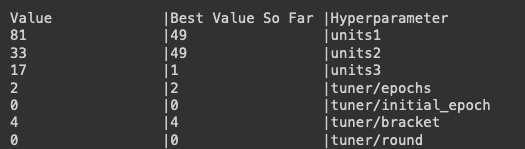

Value             |Best Value So Far |Hyperparameter
129               |49                |units1
65                |17                |units2
33                |1                 |units3
2                 |2                 |tuner/epochs
0                 |0                 |tuner/initial_epoch
4                 |4                 |tuner/bracket
0                 |0                 |tuner/round

In [ ]:
print(best_hps.values)

NameError: name 'best_hps' is not defined

In [ ]:
print("Value for hp_units1:", best_hps.get('units'))

Value for hp_units1: 129


KerasTuner output for the 2nd layer


{'units': 64, 'dropout': 0.0, 'recurrent_dropout': 0.0, 'tuner/epochs': 2, 'tuner/initial_epoch': 0, 'tuner/bracket': 4, 'tuner/round': 0}

But the val_accuracy went down so I don't think adding something here is going to work out... retest with GRU units only



In [ ]:
#create search space code

from keras.callbacks import EarlyStopping
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from tensorflow.keras.layers import Input, Embedding, GRU, Dense
from sklearn.model_selection import train_test_split
import nltk
from gensim import models
from keras.optimizers import Adam

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Custom preprocess function (if needed)
def preprocess(data):
   # Your text cleaning function here
   stop_words = set(stopwords.words('english'))
   data.translate(str.maketrans('', '', string.punctuation)).lower()
   [word for word in word_tokenize(data) if word.isalpha() and word not in stop_words]
   return data

X = dataTraining['plot'].apply(preprocess).values

# Tokenize text data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X)
sequences = tokenizer.texts_to_sequences(X)

# Pad sequences
max_sequence_length = 100  # Choose an appropriate sequence length
padded_sequences = pad_sequences(sequences, maxlen=max_sequence_length, truncating='post')  # Truncate longer sequences

# Create embedding matrix
word_index = tokenizer.word_index
num_words = len(word_index) + 1
sample_embedding = glove_model.transform(['sample'])[0] # for finding the dimension of the embedding model we are working with
embedding_dim = len(sample_embedding)
embedding_matrix = np.zeros((num_words, embedding_dim))

for word, i in word_index.items():
    if word in glove_model.model.key_to_index:
        embedding_matrix[i] = glove_model.transform([word])[0]

X_train, X_test, y_train, y_test = train_test_split(np.array(padded_sequences), y_genres, test_size=0.2, random_state=42)



# Define GRU model
model = Sequential()
model.add(Embedding(num_words, embedding_dim, weights=[embedding_matrix], input_length=max_sequence_length, trainable=False))
model.add(GRU(units=81, dropout=0.4, recurrent_dropout=0.1,return_sequences=True))
model.add(GRU(units=49,return_sequences=True))
model.add(GRU(units=49))
model.add(Dense(len(le.classes_), activation="sigmoid"))

adam_optimizer = Adam(lr=0.01) # Set the learning rate to 0.01

# Compile model
model.compile(loss='binary_crossentropy', optimizer=adam_optimizer, metrics=['accuracy'])

# Train model
model.fit(X_train, y_train, epochs=100, batch_size=16, validation_data=(X_test, y_test), callbacks=[early_stopping])


Epoch 1/100
395/395 [==============================] - 50s 115ms/step - loss: 0.3083 - accuracy: 0.1968 - val_loss: 0.2976 - val_accuracy: 0.1868
Epoch 2/100
395/395 [==============================] - 51s 129ms/step - loss: 0.2881 - accuracy: 0.2042 - val_loss: 0.2850 - val_accuracy: 0.1881
Epoch 3/100
395/395 [==============================] - 45s 115ms/step - loss: 0.2746 - accuracy: 0.2240 - val_loss: 0.2716 - val_accuracy: 0.2286
Epoch 4/100
395/395 [==============================] - 46s 115ms/step - loss: 0.2655 - accuracy: 0.2411 - val_loss: 0.2631 - val_accuracy: 0.2647
Epoch 5/100
395/395 [==============================] - 45s 115ms/step - loss: 0.2594 - accuracy: 0.2680 - val_loss: 0.2563 - val_accuracy: 0.2723
Epoch 6/100
395/395 [==============================] - 45s 115ms/step - loss: 0.2540 - accuracy: 0.2851 - val_loss: 0.2505 - val_accuracy: 0.3395
Epoch 7/100
395/395 [==============================] - 46s 116ms/step - loss: 0.2506 - accuracy: 0.2945 - val_loss: 0.2473 -

In [ ]:
y_pred_genres = model.predict(X_test)

50/50 [==============================] - 4s 42ms/step


In [ ]:
roc_auc_score(y_test, y_pred_genres, average='macro')

0.8337887391401647